In [2]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# general info
print df.info()
print df.describe() # check number of NaNs
print df.shape
print df.drop_duplicates().shape
print df.isnull().sum()

print '1:', len(df[df.y==1])
print '0:', len(df[df.y==0])

df.head()

#check duplicates
df.duplicated(keep=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 0 to 18
Data columns (total 99 columns):
home                           171 non-null int64
op                             171 non-null object
accurate_corners_intobox       171 non-null float64
accurate_freekick_cross        171 non-null float64
accurate_through_ball          171 non-null float64
aerial_won                     171 non-null int64
att_fastbreak                  171 non-null float64
att_hd_total                   171 non-null float64
backward_pass                  171 non-null int64
corner_taken                   171 non-null int64
crosses_18yard                 171 non-null float64
crosses_18yardplus             171 non-null float64
dispossessed                   171 non-null int64
dribble_lost                   171 non-null int64
duel_won                       171 non-null int64
effective_blocked_cross        171 non-null float64
effective_clearance            171 non-null int64
freekick_cross               

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x18282810>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1B30E930>]], dtype=object)

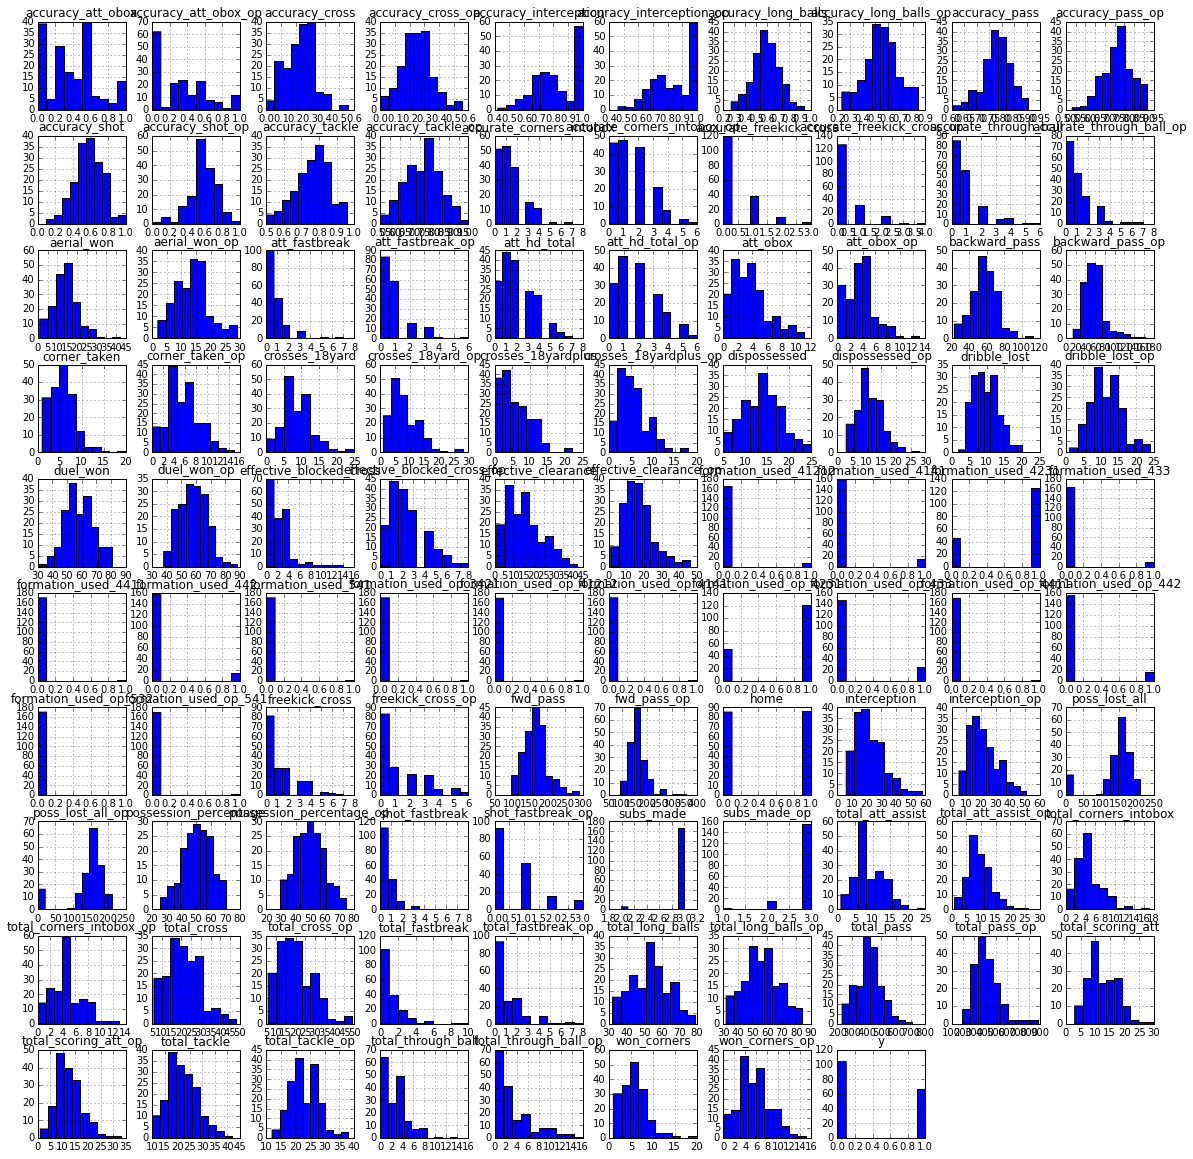

In [21]:
# hist of all vars - find types of vars
dfT.hist(figsize = (20, 20))

## Deal with missing value
#### !!!!!!!!!! -- What does NaN mean? - can I use thus info?
#### can create dummy variable regarding NaN -- riders who didn't' rate, riders who rate under 4, above 4 -- uber data challendge

In [ ]:
# check rows with NaN
df[df.isnull().any(axis=1)]

In [ ]:
# drop na
# plot dist of NaNs first, if not many
df = df.dropna()
# otherwise, do below, depending on the distribution

# impute na
#df['Age'] = df['Age'].interpolate()

# or replace with median

# or replace with a large value and later use tree-based model
df.a=df.a.fillna(9999)

## SOME EDA
#### see [harvard_cs109_lec_04_wrangling.ipynb](harvard_cs109_lec_04_wrangling.ipynb)

The basic workflow is as follows:

1. **Build** a DataFrame from the data (ideally, put *all* data in this object)
2. **Clean** the DataFrame. It should have the following properties:
   * Each row describes a single object
   * Each column describes a property of that object
   * Columns are numeric whenever appropriate
   * Columns contain atomic properties that cannot be further decomposed
   * --------------------------------------
   * remove wrong data (unreasonable value)
   * use datetime: pd.to_datetime(list)
   * --------------------------------------
3. Explore **global properties**. 
    * Check if any values are unusual
    * Check outliers
    
    also Use:
    * histograms
    * scatter plots
    * aggregation functions to summarize the data.
4. Explore **group properties**. Use groupby and small multiples to compare subsets of the data. Compare with the total



## Some of my EDA

### y vs. categorical variables

In [ ]:
for ii in ['city_name', 'signup_os', 'signup_channel', 'vehicle_type']:
    plt.figure(figsize=(6, 2))
    df.groupby(ii).mean()['y'].plot('bar', title='active rate')

### y vs. numeric variable

In [ ]:
for ii in ['bgc_after_signup', 'addv_after_signup']:

    df_pos = df[df.y == 1][ii]
    df_neg = df[df.y == 0][ii]
    plt.figure(figsize=(4, 2))
    plt.hist(df_neg.values, alpha=0.2, normed=True)
    plt.hist(df_pos.values, alpha=0.2, normed=True, color='r', )
    plt.legend(['y=0', 'y=1'])
    plt.title('hist for ' + ii)

## Some feature engineering

### binning and getting dummy

In [60]:
bins = [0, 1, 2, 3, 6]
n_san_binned = np.digitize(df.n_san, bins) # which bin is data in
df_n_san_binned = pd.get_dummies(n_san_binned)
df_n_san_binned.columns = ['san0', 'san1', 'san2', 'san345', 'sanRest']
df = pd.concat([df, df_n_san_binned], axis=1)

In [27]:
# reindex
dfT = dfT.reset_index(drop = True)

### correlation of vars

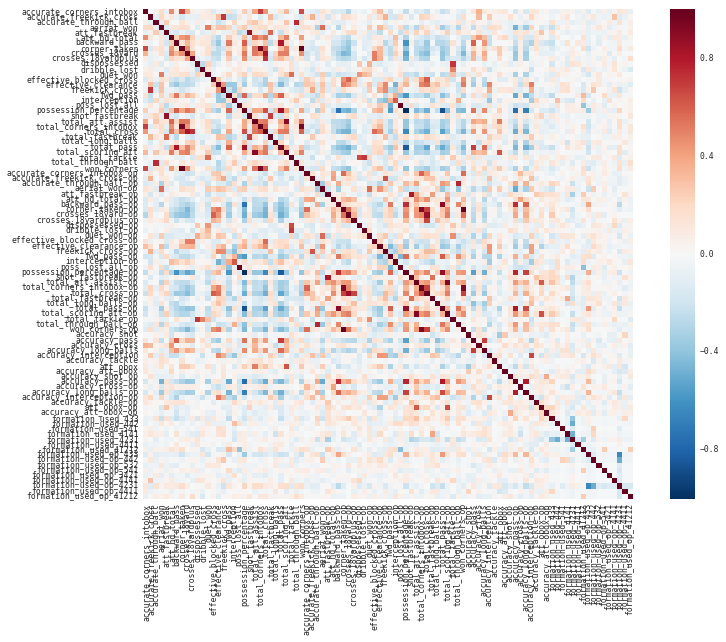

In [63]:

# remove correlated features, or features of collinearity
dropList = ['y', 'op', 'home', 'subs_made', 'subs_made_op', '1', '2', '3']
y = dfT['y'].values 
dfX = dfT.drop(dropList, 1)
corrmat = dfX.corr()


import seaborn as sns
sns.set(context="paper", font="monospace")


f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, linewidths=0, square=True)

f.tight_layout()


## Scatter of features

In [ ]:
def scatter_features(features):
    count = 0
    nrow = len(features)
    marker_size = 4
    plt.figure(figsize = (36, 36))
    for i in features:
        for j in features:
            count += 1
            plt.subplot(nrow, nrow, count)
            plt.scatter(df1[i], df1[j], color = 'r', marker = '*', s = marker_size, alpha=0.8)
            plt.scatter(df0[i], df0[j], color = 'b', marker = '*', s = marker_size, alpha=0.2)
            plt.title(i)
            if count == 1:
                plt.legend(['y=1', 'y=0'], 'upper center')
        
    #plt.savefig('scatter.png', dpi=300)
    
scatter_features(plot_cols)


## feature selection 

#### Remove correlated features
* get correlation matrix absolute value, only retain large values (>0.9)
* summing up the coefficient for each features, then remove the large ones one by one
* doing this one by one because the correlation will change after removing one

In [ ]:
df_corr = df_num.corr().abs()
max_corr = 0.9
df_corr[df_corr <= max_corr] = 0
df_corr.sum().sort_values(ascending=False)[:15]

#### remove features that don't vary -- all 0 or 1

In [ ]:
min_std = 0 # mean is around 0.01 for binary vars
features_low_var = df.std()[df.std() <= min_std].index.tolist()
features_low_var

#### univariate selection

In [1]:
from sklearn import feature_selection

# for classification (bin vars)
feature_selection.chi2(X, y)
chi_results = sorted(zip(feature_selection.chi2(X, y)[1], feature_names))  
max_chi_p_threshold = 0.1
low_chi_features = [ii[1] for ii in chi_results if ii[0] > max_chi_p_threshold]


# for regression
feature_selection.f_regression(X, y, center=True)


NameError: name 'X' is not defined

#### over/under-sampling

In [ ]:
#use the ratio of # majro data over # minor data, so that the 
#resulted new minor data will have comparable size with the major
np.random.seed(seed)
ratio_sample = len(df_major) / len(df_minor)
n_sample = np.random.choice(len(df_minor), int(len(df_minor) * ratio_sample), replace=True)
df = df_major.append(df_minor.iloc[n_sample])

In [22]:
# Groupby, join, concat
dfy = dfT.groupby('y').mean()

# join, like in R
dfJoin = merge(dfT, dfT, how = 'outer', on = [key1, key2])


### PCA

In [ ]:
pca = PCA(n_components = n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print "cumulative variance explained: ", np.cumsum(pca.explained_variance_ratio_)

# Plot PC1 vs PC2
mark_size = 10
plt.figure(figsize=(16, 6))
plt.scatter(X_train_pca[y_train==0, 0], X_train_pca[y_train==0, 1], label="Class #0", alpha=0.5, s=mark_size)
plt.scatter(X_train_pca[y_train==1, 0], X_train_pca[y_train==1, 1], label="Class #1", alpha=0.5, s=mark_size)
plt.legend()

# Plot contribution to PC1 and PC2
plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.barh(range(len(pca.components_[0])), pca.components_[0])
plt.yticks(np.arange(len(pca.components_[0])) + 0.3, features)
plt.subplot(122)
plt.barh(range(len(pca.components_[1])), pca.components_[1])
plt.yticks(np.arange(len(pca.components_[0])) + 0.3, features)

plt.show()

## Building models

In [1]:
from sklearn import linear_model 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

#### Split data

In [ ]:
########################################################################
## Split data I
########################################################################   
from sklearn import cross_validation
X, y, feature_names = ml.get_xy(df_model)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                     test_size=test_ratio, 
                                                                     random_state=random_state)


In [ ]:
########################################################################
## Split data II
########################################################################   
# Split effi data into training_cv and test parts
np.random.seed(11)
groups = np.random.choice(df_effi.group.unique(), effi_cv_sample, replace=False)
df_training_cv = df_effi[df_effi['group'].isin(groups)]
df_test = df_effi[~df_effi['group'].isin(groups)]

'''
# random sample to get training and testing set
import random
rows = random.sample(dfT.index, 100)
dftrain = dfT.ix[rows]
dftest = dfT.drop(rows)
'''


df_training_cv = df_training_cv.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print '\n# of windows in training_cv and testing:', len(df_training_cv), len(df_test), '\n'
_, _, scaler = normalizer(df_training_cv)


#### some functions for model building

In [ ]:
def normalizer(df, scaler=None):
    """
    get data and normalize, return scaled data and the scaler
    if a scaler is not provided, return the scaler based on the current data
    """
    
    y = df['y'].values
    X = df.drop(['y', 'source', 'group'], axis=1).values
    if not scaler:
        scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    return X_scaled, y, scaler

def train_learner(model_type, param_grid, scaler, df_training, n_cv, n_jobs, scoring):
    '''
    fit model with training data; optimizing hyperparameters using grid search
    '''  
    X_training_scaled, y_training, _ = normalizer(df_training, scaler=scaler)
    model_pipe = model_type(random_state=1)   
    modelCV = GridSearchCV(model_pipe, param_grid=param_grid, cv=n_cv, n_jobs=n_jobs, scoring=scoring)
    modelCV.fit(X_training_scaled, y_training) 
    print 'best score: ' + str(modelCV.best_score_) #training performance 
    return modelCV.best_estimator_


def predict_test_from_cv(df_test, learner, scaler):
    """
    predict on test data -- this is mimicing the online prediction by averaging scores over a block    
    """

    X_test_scaled, y_test, _ = normalizer(df_test, scaler=scaler)
    df_raw_score = df_test[['group', 'y']].copy()

    score = learner.predict_proba(X_test_scaled)[:, 1]

    # Average scores of all windows in each block/group to get the block score
    df_raw_score['score'] = score
    df_score = df_raw_score.groupby('group').mean() # The mean of ys is the same y in each group
    df_score['pred'] = (df_score.score > 0.5).astype('int')
    df_score.index = np.arange(len(df_score))
    test_performance = {'Precision': metrics.precision_score(df_score['y'], df_score['pred']), 
                   'Recall': metrics.recall_score(df_score['y'], df_score['pred']),
                   'F1': format(metrics.f1_score(df_score['y'], df_score['pred']))}

    return {'df_score': df_score, 'test_performance': test_performance}

# From sklearn
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=random_state)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

In [ ]:
########################################################################
## Build the model and save
########################################################################        
# Build a RFC
param_space = {'max_features': np.arange(1, 5),
               'min_samples_split': np.arange(1, 10, 2),
               'min_samples_leaf': np.arange(1, 10, 2),
               'n_estimators': [1000, 3000, 10000]
              }
model_type = RandomForestClassifier
learner = train_learner(model_type, param_space, scaler, df_training_cv, n_cv, n_jobs, scoring)

predict_test_from_cv(df_test, rand_forest, scaler)    

In [ ]:

# RF classifier
clfRF = RandomForestClassifier(random_state = 1, n_estimators = nTrees)
clfRf.fit(X_train, y_train)
importances = clfRF.feature_importances_
sorted_idx = np.argsort(importances)
nTrees = 100

# Log reg
model2 = linear_model.LogisticRegression(penalty = 'l1')
model2.fit(X_train, y_train)
predicted_score = model2.predict_proba(X_test)[:, 1]
predicted = model2.predict(X_test)

# check the performance
roc_auc = metrics.roc_auc_score(y_test, predicted_score)
acc = metrics.accuracy_score(y_test, predicted)
moreMet = metrics.classification_report(y_test, predicted)


In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = metrics.roc_curve(y_test, predicted_score)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#or ml.plot_roc

In [ ]:
# Feature importance
importances = clfRF.feature_importances_
sorted_idx = np.argsort(importances)
importances = importances[sorted_idx]
features = dfFiltered.drop('reply_content_type', axis = 1).columns[sorted_idx]
y_pos = np.arange(len(features))

plt.barh(y_pos, importances, align='center', alpha=0.4)
plt.yticks(y_pos, features)
plt.xlabel('importances')
plt.title('features')

plt.show()

#or ml.plot_importance